# Scattering SVM classificaiton
* Turn ECG measurement into feature vector using scattering
* use SVM for classification

In [2]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from utilities.utils import CustomDataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

In [3]:
import utilities.data_loader as data_loader
import utilities.filter_data as filter_data
import importlib
importlib.reload(data_loader)
importlib.reload(filter_data)

<module 'utilities.filter_data' from '/mnt/c/Users/phil/university/verona/visual-intelligence-ecg-project/utilities/filter_data.py'>

## Loading Data

In [4]:
data_path = "data/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/"
ecg_data_path = data_path + "WFDBRecords/"

In [5]:
importlib.reload(data_loader)
data = data_loader.load_number_of_random_samples(ecg_data_path, 1000)
# data = data_loader.load_number_of_random_samples_balanced(ecg_data_path, 500)

Loaded 1000 of 1000


In [6]:
healty_samples = [entry for entry in data if entry['binary_label'] == 0]
unhealty_samples = [entry for entry in data if entry['binary_label'] == 1]
print(f"Number of healty samples: {len(healty_samples)}")
print(f"Number of unhealty samples: {len(unhealty_samples)}")

Number of healty samples: 795
Number of unhealty samples: 205


In [7]:
# count how many nan in X
X = np.array([entry['data'] for entry in data], dtype=np.float32)
print(np.isnan(X).sum())

2


In [8]:
X = np.nan_to_num(X)
y = np.array([entry['binary_label'] for entry in data], dtype=np.float32)
print(X.shape)
print(y.shape)

(1000, 5000, 12)
(1000,)


In [9]:
# make sure no nan values
if np.isnan(X).any():
    print("!!!X contains NaN!!!")
else:
    print("X does not contain NaN")

X does not contain NaN


## Filtering Data

In [10]:
# remove baseline wander using DWT
for index in range(X.shape[0]):
    if index % 10 == 0 or index == X.shape[0] - 1:
        clear_output(wait=True)
        print(f"Removing baseline wander sample {index + 1}/{X.shape[0]}")
    for channel in range(X.shape[2]):
        X[index, :, channel] = filter_data.apply_dwt_to_eliminate_baseline_wander(X[index, :, channel], hard_threshold=True)
        # X[index, :, channel] = filter_data.fir_filter_to_eliminate_baseline_wander(X[index, :, channel])  # to slow...

print("Count nan: ", np.isnan(X).sum())

Removing baseline wander sample 1000/1000
Count nan:  0


In [11]:
# remove power line interference using notch filter
for index in range(X.shape[0]):
    if index % 50 == 0 or index == X.shape[0] - 1:
        clear_output(wait=True)
        print(f"Removing power line interference sample {index + 1}/{X.shape[0]}")
    for channel in range(X.shape[2]):
        X[index, :, channel] = filter_data.apply_notch_filter(X[index, :, channel])
print("Count nan: ", np.isnan(X).sum())

Removing power line interference sample 1000/1000
Count nan:  0


In [12]:
# TODO: some issues with infinity, fix...
# remove EMG noise and electrode motion artifacts using adaptive filter
importlib.reload(filter_data)
# for index in range(X.shape[0]):
#     # if index % 20 == 0 or index == X.shape[0] - 1:
#     #     clear_output(wait=True)
#     #     print(f"Removing EMG noise sample {index + 1}/{X.shape[0]}")
#     for channel in range(X.shape[2]):
#         X[index, :, channel] = filter_data.apply_adaptive_filter(X[index, :, channel])
# print("Count nan: ", np.isnan(X).sum())

<module 'utilities.filter_data' from '/mnt/c/Users/phil/university/verona/visual-intelligence-ecg-project/utilities/filter_data.py'>

In [13]:
# TODO: read this!!! https://www.researchgate.net/publication/347930656_Comparative_Study_on_the_Effect_of_Order_and_Cut_off_Frequency_of_Butterworth_Low_Pass_Filter_for_Removal_of_Noise_in_ECG_Signal
# cutoff_frequency = 50  # TODO: find good value
# for index in range(X.shape[0]):
#     if index % 50 == 0 or index == X.shape[0] - 1:
#         clear_output(wait=True)
#         print(f"Filtering sample {index + 1}/{X.shape[0]}")
#     for channel in range(X.shape[2]):
#         X[index, :, channel] = filter_data.apply_low_pass_filter(X[index, :, channel], cutoff_frequency)
# print("Count nan: ", np.isnan(X).sum())

In [14]:
# TODO: implement LOESS filter?!

## Data into dataset

In [15]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1905)

# scale each channel on its own:
for channel in range(X_train.shape[2]):
    scaler = StandardScaler()
    X_train[:,:,channel] = scaler.fit_transform(X_train[:,:,channel])
    X_test[:,:,channel] = scaler.transform(X_test[:,:,channel])
    

# make sure mean zero and unit variance
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
# X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)




In [16]:
print(X_train.shape)

(800, 5000, 12)


## Model

In [17]:
import torch
from torch.nn import Linear, NLLLoss, LogSoftmax, Sequential
from torch.optim import Adam
from sklearn.metrics import confusion_matrix
from kymatio.torch import Scattering1D
from kymatio.datasets import fetch_fsdd

In [18]:
# TODO: implement cuda!
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(1905)
if use_cuda:
    print("Using GPU")

Using GPU


In [19]:
print(X_train.shape)

(800, 5000, 12)


In [20]:
T = X_train.shape[1]
# TODO: find good values, maybe increase Q
J = 8  # number of scales
Q = 8  # number of wavelets per octave
log_eps = 1e-6
# scattering = Scattering1D(J, T, Q).to(device)
scattering = Scattering1D(J, shape=X_train.shape[1], Q=Q).to(device)


# 4 12 -> 0.67
# 6 12 -> 0.66
# 8 12 -> 0.85
# 10 12 -> 0.77
# 12 12 -> 0.79

# 8 3 -> 0.88
# 8 6 -> 0.85
# 8 8 -> 0.89


### Train set

In [21]:
# TODO: move scattering into nn module class
scattering_results_np = []
standard_scaler_per_channel = []
for channel in range(X_train.shape[2]):
    clear_output(wait=True)
    print(f"Scattering channel {channel + 1}/{X_train.shape[2]}")
    scattering_result = scattering.forward(torch.from_numpy(np.ascontiguousarray(X_train[:, :, channel])).to(device))
    scattering_result = scattering_result[:, 1:,:]  # remove zeroth order scattering coefficients
    scattering_result = scattering_result.double()
    
    # for preventing small values
    scattering_result = torch.log(torch.abs(scattering_result) + log_eps)
    print(scattering_result.shape)
    scattering_result = torch.mean(scattering_result, dim=-1)
    print(scattering_result.shape)
    
    
    # standard scaler
    # probably dont use for now?
    scattering_result = torch.Tensor.cpu(scattering_result)
    # scaler = StandardScaler()
    # scattering_result = scaler.fit_transform(scattering_result)
    # standard_scaler_per_channel.append(scaler)
    
    scattering_results_np.append(scattering_result)

Scattering channel 12/12
torch.Size([800, 233, 19])
torch.Size([800, 233])


In [22]:
scattering_results_np = np.array(scattering_results_np)
print(scattering_results_np.shape)

(12, 800, 233)


In [23]:
if np.isnan(scattering_results_np).any():
    print("!!!Scattering results contains NaN!!!")
else:
    print("Scattering results does not contain NaN")

Scattering results does not contain NaN


In [24]:
y_train

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 1.

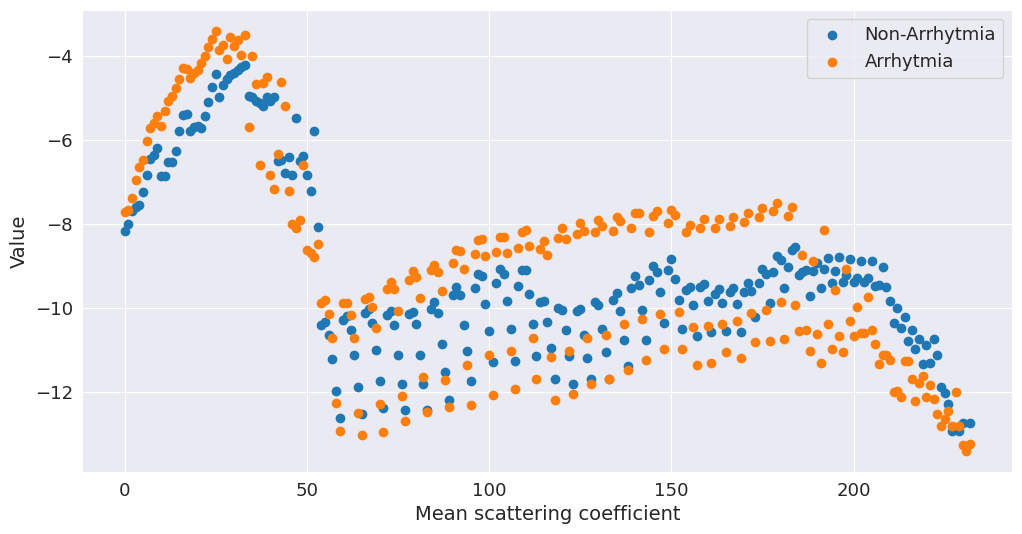

In [25]:
sample_channel = 9
healty_index = 10
unhealty_index = 11
plt.figure(figsize=(12,6))
plt.scatter(np.arange(len(scattering_results_np[sample_channel, healty_index, :])), scattering_results_np[sample_channel, healty_index, :], label="Non-Arrhytmia")
plt.scatter(np.arange(len(scattering_results_np[sample_channel, unhealty_index, :])), scattering_results_np[sample_channel, unhealty_index, :], label="Arrhytmia")
plt.xlabel("Mean scattering coefficient")
plt.ylabel("Value")
plt.legend()
plt.show()

### RFE for displaying most important features

In [26]:
# use 3 fixed number of features to plot
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
estimator = SVC(kernel='linear')  # needs to use kernel linear
sel_rfe = RFE(estimator, n_features_to_select=3, step=1)
X_train_rfe = sel_rfe.fit_transform(scattering_results_np[sample_channel], y_train)
print(X_train_rfe.shape)

(800, 3)


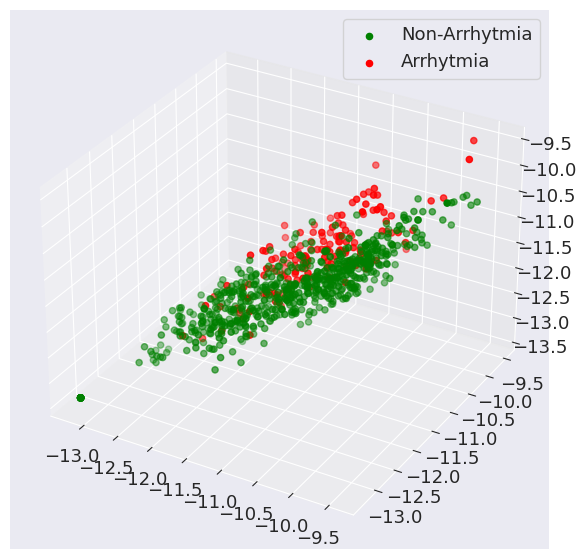

In [27]:
# columns = X_column_names[sel_rfe.get_support(indices=True)]
class_zero = X_train_rfe[y_train == 0]
class_one = X_train_rfe[y_train == 1]
class_two = X_train_rfe[y_train == 2]
class_three = X_train_rfe[y_train == 3]
class_four = X_train_rfe[y_train == 4]
class_five = X_train_rfe[y_train == 5]
# Creating figure
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection="3d")

# Creating plot
ax.scatter3D(class_zero[:, 0], class_zero[:, 1], class_zero[:, 2], color="green", label="Non-Arrhytmia")
ax.scatter3D(class_one[:, 0], class_one[:, 1], class_one[:, 2], color="red", label = "Arrhytmia")
# ax.scatter3D(class_two[:, 0], class_two[:, 1], class_two[:, 2], color="blue", label = "Walking downstairs")
# ax.scatter3D(class_three[:, 0], class_three[:, 1], class_three[:, 2], color="yellow", label = "Sitting")
# ax.scatter3D(class_four[:, 0], class_four[:, 1], class_four[:, 2], color="black", label = "Standing")
# ax.scatter3D(class_five[:, 0], class_five[:, 1], class_five[:, 2], color="orange", label = "Laying")
# set x label
# ax.set_xlabel(columns[0])
# ax.set_ylabel(columns[1])
# ax.set_zlabel(columns[2])
# ax.set_xlim([-2, 1])
# ax.set_ylim([0, 5])
# ax.set_zlim([-10, 2])
plt.legend()
# plt.title("RFE with three features")
plt.show()

In [28]:
# just check how many and which features are the most important for SVC
estimator = SVC(kernel='linear')  # needs to use kernel linear
sel_rfe = RFE(estimator, n_features_to_select=10, step=1)
X_train_rfe = sel_rfe.fit_transform(scattering_results_np[sample_channel], y_train)
print(sel_rfe.get_support(indices=True))

[ 32  37  39 193 205 211 217 220 221 232]


In [29]:
from sklearn.decomposition import PCA
sel_pca = PCA(n_components=3, svd_solver='auto')
X_train_pca = sel_pca.fit_transform(scattering_results_np[sample_channel])
print(X_train_pca.shape)

(800, 3)


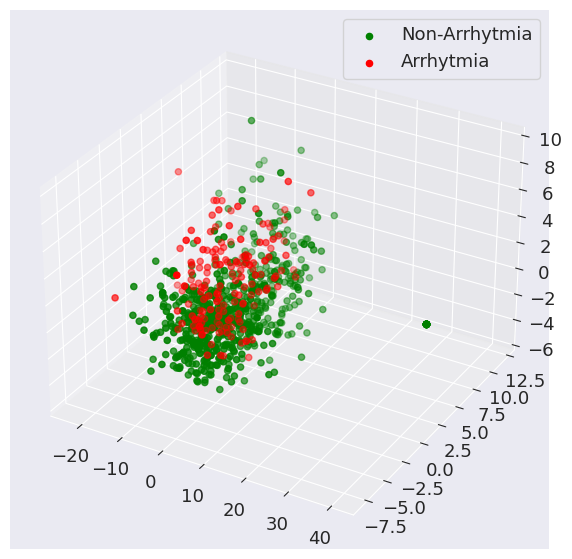

In [30]:
# plotting PCA with 3 components
class_zero = X_train_pca[y_train == 0]
class_one = X_train_pca[y_train == 1]
# Creating figure
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection="3d")

# Creating plot
ax.scatter3D(class_zero[:, 0], class_zero[:, 1], class_zero[:, 2], color="green", label="Non-Arrhytmia")
ax.scatter3D(class_one[:, 0], class_one[:, 1], class_one[:, 2], color="red", label = "Arrhytmia")
plt.legend()
plt.show()

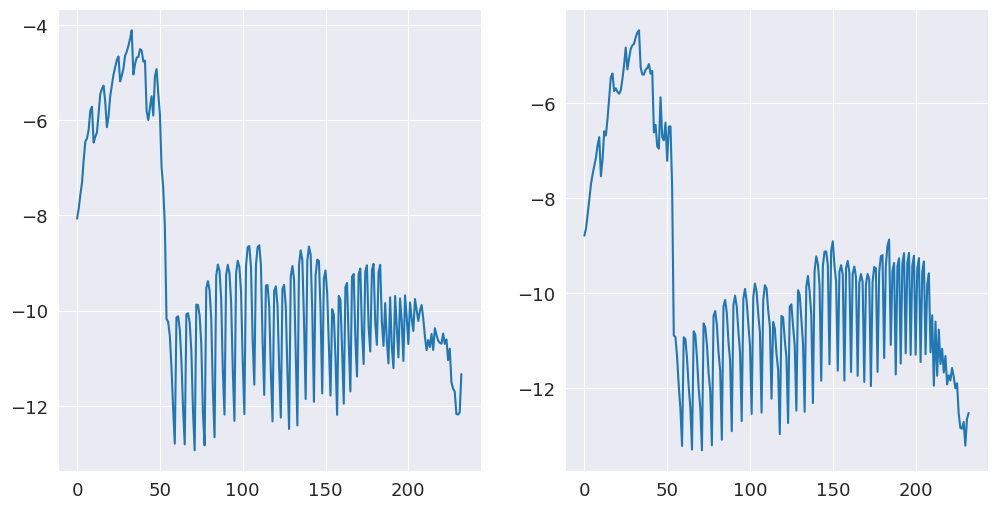

In [31]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(scattering_results_np[7, 0, :])
plt.subplot(1,2,2)
plt.plot(scattering_results_np[7, 1, :])
plt.show()

### Test set

In [32]:
test_scattering_results_np = []
for channel in range(X_test.shape[2]):
    clear_output(wait=True)
    print(f"Scattering channel {channel + 1}/{X_test.shape[2]}")
    scattering_result = scattering.forward(torch.from_numpy(np.ascontiguousarray(X_test[:, :, channel])).to(device))
    scattering_result = scattering_result[:, 1:,:]  # remove zeroth order scattering coefficients
    scattering_result = scattering_result.double()
    
    
    scattering_result = torch.log(torch.abs(scattering_result) + log_eps)
    scattering_result = torch.mean(scattering_result, dim=-1)
    
    scattering_result = torch.Tensor.cpu(scattering_result)
    # only scale if train data was also scaled
    if standard_scaler_per_channel is not None and len(standard_scaler_per_channel) > 0:
        scattering_result = standard_scaler_per_channel[channel].transform(scattering_result)

    test_scattering_results_np.append(scattering_result)

test_scattering_results_np = np.array(test_scattering_results_np)

if np.isnan(test_scattering_results_np).any():
    print("!!!Scattering results contains NaN!!!")
else:
    print("Scattering results does not contain NaN")
print(test_scattering_results_np.shape)

Scattering channel 12/12
Scattering results does not contain NaN
(12, 200, 233)


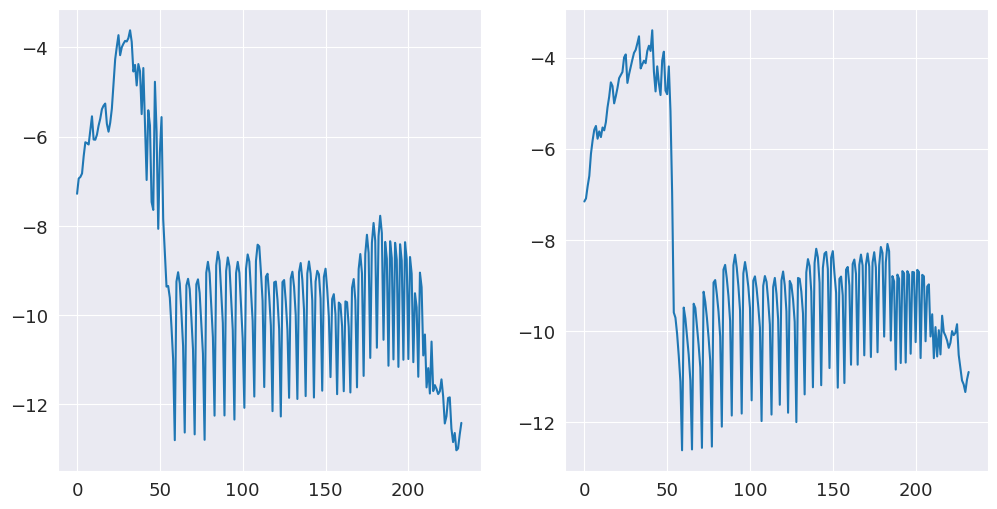

In [33]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(test_scattering_results_np[7, 0, :])
plt.subplot(1,2,2)
plt.plot(test_scattering_results_np[7, 2, :])
plt.show()

In [34]:
# scattering_results_np
# y_train
# test_scattering_results_np
# y_test
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

In [35]:
scattering_results_np.shape


(12, 800, 233)

In [36]:
predictions = np.zeros(len(y_test))
for channel in range(scattering_results_np.shape[0]):
    grid_search_svc_parameters = {'C':[0.5, 1, 2,8,16], 'gamma': [ 'auto', 0.125, 0.5, 1, 2], 'kernel': ['rbf', 'linear']}
    clf = GridSearchCV(SVC(), grid_search_svc_parameters, n_jobs=-1)
    clf = clf.fit(scattering_results_np[channel], y_train)
    y_pred = clf.predict(test_scattering_results_np[channel])
    predictions += y_pred
    accuracy = accuracy_score(y_test, y_pred)
    print("channel: ", channel, " - acc: ", accuracy)

channel:  0  - acc:  0.905
channel:  1  - acc:  0.925
channel:  2  - acc:  0.895
channel:  3  - acc:  0.95
channel:  4  - acc:  0.89
channel:  5  - acc:  0.915
channel:  6  - acc:  0.91
channel:  7  - acc:  0.9
channel:  8  - acc:  0.925
channel:  9  - acc:  0.915
channel:  10  - acc:  0.9
channel:  11  - acc:  0.91


In [37]:
combined_preds = []
for i in range(len(predictions)):
    if predictions[i] > 6:
        combined_preds.append(1)
    else:
        combined_preds.append(0)

In [38]:
accuracy_score(y_test, combined_preds)

0.93

In [39]:
confusion_matrix(y_test, combined_preds, normalize='pred')

array([[0.94339623, 0.12195122],
       [0.05660377, 0.87804878]])